In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

# Ex 1: Prove of the Policy Gradient Theorem via the Performance Difference Lemma (20 points)

Denote $J(\pi) = \langle \mu, V^\pi \rangle$ and recall that the performance difference lemma states
$$
J(\pi) - J(\pi') = \frac{1}{(1-\gamma)}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]
$$
where $\lambda^{\pi'} \in \Delta_{\mathcal{S}\times\mathcal{A}}$ denotes the occupancy measure of the policy $\pi'$.

Now let us consider direct parametization, and compute a partial derivative for the entry of $\pi$ at index $(\bar{s},\bar{a})$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})}.
$$

**Questions**

To help you compute this partial derivative, consider the policies $\pi'$ parameterized by some (sufficiently small) $\delta \in \mathbb{R}$ via
$$
    \pi'(a|s) = \begin{cases}
        \pi(\bar{a}|\bar{s}) + \delta \quad (\text{if } (s,a)=(\bar{s},\bar{a}))\\
        \pi(a|s) \quad (\text{else})
    \end{cases}
$$

(1) Argue that
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} =\lim_{\delta \rightarrow 0} \frac{\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}.
$$

**Answer**

Once can argue that this is just the definition of the derivative at the point $(\bar{s},\bar{a})$ with respect to $\pi(\bar{a}|\bar{s})$. The $J(\pi) - J(\pi')$ is the "$\Delta y$" in the slope equation and $\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})$ is the "$\Delta x$". This gives us the slope of the curve between two points $\pi$ and $\pi'$ and then we need to make sure that $\Delta x$ goes to 0 in order to get the derivative at the point $(\bar{s},\bar{a})$ wrt $\pi(\bar{a}|\bar{s})$.

(2) Argue that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a}).$$

Hint: Write the expectation in the previous question as a sum and use the fact that $\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} = \mathbf{1}_{\{ (\bar{s},\bar{a}) = (s,a) \}}$.

**Answer**

Lets rewrite the expectations on the RHS of the partial derivative in its sum form.
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \frac{\sum_{s}\lambda^{\pi'}(s) \sum_{a}(\pi(a|s) - \pi'(a|s)) Q^\pi(s,a)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}
$$
Now we notice that the sum is only non-zero when $(s, a) = (\bar{s}, \bar{a})$. This gives us the following result:
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \frac{\lambda^{\pi'}(\bar{s}) [\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})] Q^\pi(\bar{s}, \bar{a})}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}
$$
From which we get our desired result:
$$
\boxed{\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a})}
$$

(3) Conclude that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})$$
for the direct parameterization. 

**Answer**

Since we let delta go to 0, $\pi'(\bar{a}|\bar{s}) = \pi(\bar{a}|\bar{s})$ and thus$
$$
\boxed{\frac{\partial J(\pi)}{\pi(\bar{a} | \bar{s})} = \lim_{\delta \rightarrow 0} \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a}) = \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})}
$$

(4) Prove that for a general parametrization, it holds that
$$
\nabla_\theta J(\pi_\theta) = \sum_{\bar{s},\bar{a}} \lambda^{\pi}(\bar{s}, \bar{a}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))
$$

Hint: Use the chain rule to write $$ \nabla_\theta J(\pi_\theta)  = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s}), $$
and then use the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$.

**Answer**

From the hint, we use the chain rule to write:
$$
\nabla_{\theta}J(\pi_{\theta}) = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})
$$

Now we can substitute the result we derived above to get:
$$
\nabla_{\theta}J(\pi_{\theta}) = \sum_{\bar{s}, \bar{a}} \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})
$$

Again from the hint we make use of the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$ to write:
$$
\nabla_{\theta}J(\pi_{\theta}) = \sum_{\bar{s}, \bar{a}} \lambda^{\pi}(\bar{s}, \bar{a}) Q^{\pi}(\bar{s}, \bar{a}) \frac{\nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})}{\pi_\theta(\bar{a}|\bar{s})}
$$

We then make use of the identity that $\nabla\log{x} = \frac{\nabla x}{x}$ (considering log to be the natual log):
$$
\boxed{\nabla_{\theta}J(\pi_{\theta}) = \sum_{\bar{s}, \bar{a}} \lambda^{\pi}(\bar{s}, \bar{a}) Q^{\pi}(\bar{s}, \bar{a}) \nabla_{\theta} \log{(\pi_\theta(\bar{a}|\bar{s}))}}
$$

# Ex 2: Natural Policy Gradient with softmax parameterization (20 points)

Recall that the iterates $\{\pi^t\}^{\infty}_{t=1}$ produced by NPG read as follows:
$$
\pi^{t+1}(a|s) = \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}.
$$

**Question** 

Implement NPG for an arbitrary step size $\eta$. Please note that $e^{\eta Q^{\pi^t}(s,a)}$ can be zero, account for that in your implementation.

In [2]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy stochastic passed with shape n_states times n_actions
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s].dot(pi[s])
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

def npg_update(q, eta, old_policy):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        new_policy: the updates policy
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        if np.isinf(eta):
            policy[s, np.argmax(q[s,:])] = 1
        else:
            numerator = old_policy[s] * np.exp(eta*q[s])
            policy[s] = numerator / (np.sum(numerator) + 1e-10)
    return policy

def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s,np.argmax(q[s,:])] = 1
    return policy

In [3]:
def NPG(env, eta): # apply NPG iterations for 30 steps
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.ones_like(q)/env.n_actions
    for k in range(30):
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env)
        if eta < np.inf:
            pi = npg_update(q, eta, pi)
        else:
            pi = get_greedy_policy(q)
        vs.append(v)
        policies.append(pi)
    return vs, policies

Now, we run NPG for different stepsizes in the usual gridworld environment

In [4]:
from tqdm import tqdm

reward_mode = 2
size = 10 
prop = 0
gamma=0.99
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
mu = np.ones(gridworld.n_states)/gridworld.n_states
etas = [1e-3, 1e-2, 1e-1, 1, 100, 1e7, np.inf]
v_different_etas = []
pi_different_etas = []
for eta in tqdm(etas):
    values_pi, policies = NPG(gridworld, eta=eta)
    v_different_etas.append(values_pi)
    pi_different_etas.append(policies)

100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


In [5]:
solver = MDPsolver(gridworld)
solver.value_iteration()

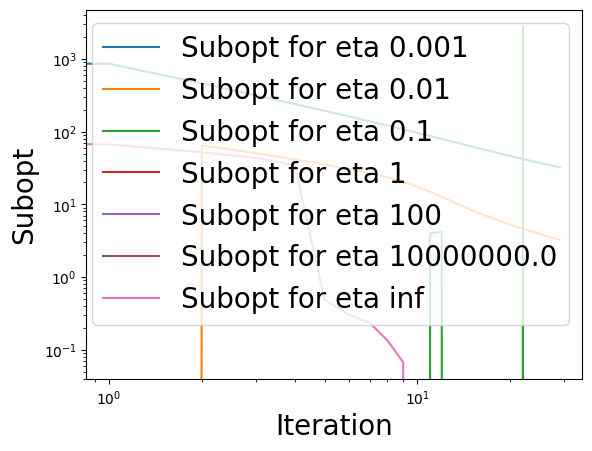

In [6]:
# TODO: if this plot appears with a too large legend, rerun this line once more
plot_log_lines([np.array([mu.dot(solver.v - v) for v in v_different_etas[i]]) for i, _ in enumerate(etas)], [f"Subopt for eta {eta}" for eta in etas], ["Iteration", "Subopt"], "figs", "NPG.pdf", show = True)

**Question**

Show that NPG with $\eta = \infty$ coincides with Policy Iteration (PI).

More formally: Assuming that $a^\star_s := \mathrm{argmax}_a Q^{\pi^t}(s,a)$ is unique for all $s$, prove that $$ \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases},$$
and explain how this relates to PI.

**Answer**

Ok so first we fix a state $s \in \mathcal{S}$ and define $a^{\star}_{s} = \argmax_a Q^{\pi^t}(s,a)$.
Then we can write:
$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a)\exp{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a') \exp{\eta Q^{\pi^t}(s,a')}}
$$
We then let $M = \max_{a} Q^{\pi^t}(s,a)$ and then we have:
$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a)\exp{\eta Q^{\pi^t}(s,a) }}{\sum_{a'}\pi^t(a') \exp{\eta (Q^{\pi^t}(s,a') - M)}\exp(\eta M)}
$$
$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a)\exp{\eta (Q^{\pi^t}(s,a) - M)}}{\sum_{a'}\pi^t(a') \exp{\eta (Q^{\pi^t}(s,a') - M)}}
$$

Then we can see that:
 - $Q(s, a) - M < 0 \text{ if } a \neq a^{\star}$
 - $Q(s, a) - M = 0 \text{ if } a = a^{\star}$

We can then split up the sum in the denominator:
$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a)\exp{\eta (Q^{\pi^t}(s,a) - M)}}{\pi^t(a^{\star})\exp{0} + \sum_{a' \neq a^{\star}}\pi^t(a') \exp{\eta (Q^{\pi^t}(s,a') - M)}}
$$

Now the second term in the denominator goes to 0 as $\eta \rightarrow \infty$. In the numerator we only get a non-zero answer if $a = a^{\star}$, in that case the answer is 1. Gathering this information together we can see that this is the same as PI and we arrive at the following definition:

$$
\boxed{
    \begin{align*}
        \lim_{\eta \rightarrow \infty} \frac{\pi^t(a)\exp{\eta (Q^{\pi^t}(s,a) - M)}}{\pi^t(a^{\star})\exp{0} + \sum_{a' \neq a^{\star}}\pi^t(a') \exp{\eta (Q^{\pi^t}(s,a') - M)}} &= \begin{cases} 1 \quad \text{if} \quad a = a^{\star} \\ 0 \quad \text{otherwise} \end{cases} \\
        \Leftrightarrow \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)\exp{{\eta Q^{\pi^t}(s,a)} }}{\sum_{a'} \pi^t(a'|s) \exp{\eta Q^{\pi^t}(s,a')}} &= \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases}
    \end{align*}
}
$$

Which is equivalent to what question asked us to prove


**Question**

Is this observation in line with the empirical results in the plot above? I.e., is the plot for $\eta = \infty$ as you would expect it for PI?

**Answer**

Yes this plot is similar to the plots we saw in Homework 1 when working with the PI algorithm.

# Ex 2.1 Slow Changing Property of NPG

In this exercise you will investigate by how much consecutive iterates $\pi^t$ and $\pi^{t+1}$ produced by NPG differ and how this distance is controlled by the step size $\eta$.

Plot $$\max_{s \in \mathcal{S}} || \pi^{t+1}(a|s) - \pi^t(a|s) ||_1$$ for different values of $\eta$.

In [7]:
def compute_policy_variation(policies):
    variation = []
    for pi, pip in zip(policies[1:], policies[:-1]):
        variation.append(np.max([ np.linalg.norm(pi[s] - pip[s], 1) for s in range(pi.shape[0])]))
    return variation

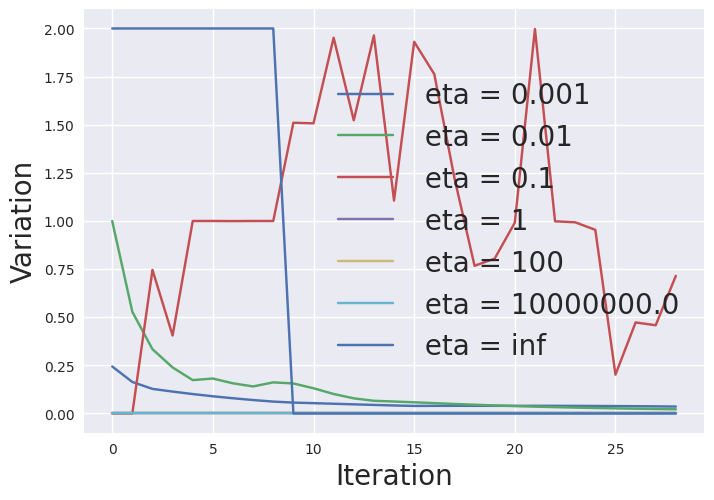

In [8]:
plot_lines(np.array([ compute_policy_variation(np.array(pi_different_etas)[i])
                           for i, _ in enumerate(etas)]), 
               [f" eta = {eta}" for eta in etas], 
               ["Iteration", "Variation"], "figs", "NPG.pdf", show = True)

**Question**

Empirically, is the largest change (among all iterations) between consecutive iterations is larger for smaller or large values of $\eta$?

It is smaller for larger values of $\eta$

## Some Theory to Motivate the Observation Above

**Question**

Our goal is to prove that $$ || \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T].$$

We guide you towards this result by breaking the proof into small steps.

1) Prove that $$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) $$

Hint: First apply Pinkser's inequality https://en.wikipedia.org/wiki/Pinsker%27s_inequality to prove that $$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq KL(\pi^{t+1}(s)||\pi^t(s)), $$ then plug in the formula for $\pi^{t+1}$ into the KL term.

**Answer**

Using the hint provided we first start off by using Pinsker's inequality to get:

$$
\lVert \pi^{t+1}(s) - \pi^t(s) \rVert_1 \leq \sqrt{2\operatorname{KL}(\pi^{t+1}(s) || \pi^{t}(s))}
$$

By squaring both sides and rearranging the terms we get:

$$
\frac{1}{2}\lVert \pi^{t+1}(s) - \pi^{t}(s) \rVert_1^2 \leq \operatorname{KL}(\pi^{t+1}(s) || \pi^{t}(s))
$$

We can now substitute terms into the KL divergence to get:
$$
\begin{align*}
    \frac{1}{2}\lVert \pi^{t+1}(s) - \pi^{t}(s) \rVert_1^2 &\leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}\left[\log\left(\frac{\exp(\eta Q^{\pi^{t}(s, a)})}{\sum_{a'\in \mathcal{A}}\pi^{t}(s, a') \exp(\eta Q^{\pi^{t}(s, a')})}\right)\right]
\end{align*}
$$
Since the denominator is a constant wrt to the expection we can pull it out of the expectation and arrive at out final answer:

$$
\boxed{
\frac{1}{2}\lVert \pi^{t+1}(s) - \pi^{t}(s) \rVert_1^2 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg).
}
$$



2) Prove that 
$$
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) = \frac{1}{\sum_{a'\in \mathcal{A}} \pi^t(a|s) \exp(\eta Q^{\pi^t}(s,a) )}.
$$

**Answer**

To prove the equation above we can substitute in the definition of $\pi^{t+1}$:

$$
\begin{align*}
\sum_{a \in \mathcal{A}} \pi^{t+1}(a | s)\exp(-\eta Q^{\pi^t}(s, a)) &= \sum_{a \in \mathcal{A}} \frac{\pi^t(a | s) \exp(\eta Q^{\pi^t}(s, a)) \exp(-\eta Q^{\pi^t}(s, a)}{\sum_{a' \in \mathcal{A}} \pi^t(a' | s) \exp(\eta Q^{\pi^t}(s, a'))} \\
&= \frac{1}{\sum_{a' \in \mathcal{A}} \pi^t(a' | s) \exp(\eta Q^{\pi^t}(s, a'))}\left[\sum_{a \in \mathcal{A}} \pi^t(a | s)\right] \\

&\boxed{
    = \frac{1}{\sum_{a' \in \mathcal{A}} \pi^t(a' | s) \exp(\eta Q^{\pi^t}(s, a'))} 
}

\end{align*}
$$


3) Using the results in 1) and 2) prove that 

$$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg). $$

**Answer**

We begin by rewriting our results from 1):
$$
\mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) = \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \frac{1}{(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a')))}
$$

Then we can substitute out result from 2) into the log term to get the inequaltiy:

$$
\boxed{
    \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg)
}
$$

4) Using Hoeffding's Lemma https://en.wikipedia.org/wiki/Hoeffding%27s_lemma (on the sum in the log term!) and the fact that $$-\frac{1}{1-\gamma} \leq Q^{\pi^t}(s,a) \leq \frac{1}{1-\gamma},$$ conclude that 
$$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}.$$

**Answer**

We can rewrite the sum inside the log as an expectation:

$$
\sum_{a' \in \mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a')) = \mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[\exp (-\eta Q^{\pi^t}(s,a'))]
$$

This then allows us to use Hoeffding's Lemma (as the question suggested) to get:

$$
\begin{align*}
\mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] &\leq \exp\left(-\eta\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^{2}(\frac{1}{1-\gamma} + \frac{1}{1-\gamma})^2}{8} \right)\\

&= \exp\left(-\eta\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^{2}(\frac{2}{1-\gamma})^2}{8} \right) \\

&= \exp\left(-\eta\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2(1-\gamma)^2} \right) \\
\end{align*}
$$

Now we can substitute this back into the original equation to get:
$$
\begin{align*}
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 &\leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg) \\
&\leq \eta\mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a)] + \log\left(\exp\left(-\eta\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2(1-\gamma)^2} \right)\right) \\
&= \eta\mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a)] -\eta\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2(1-\gamma)^2} \\
&= \frac{\eta^2}{2(1-\gamma)^2}
\end{align*}
$$

And so we have shown that:

$$
\boxed{
    \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}
}

$$


To finish the proof we can multiply by 2 and take the square root to get:
$$
\boxed{
|| \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T]
}
$$

# Ex 3: OPPO: The importance of Exploration in Policy Gradient (20 points)

In this exercise, we will investigate how crucial it is to perform exploration. That is, adding bonuses to avoid suffering the mismatch coefficients in the convergence bounds.

Let us recall that the standard sample based version of NPG suffers the mismatch coeffcients in the bounds (see Slide 22 in Lecture 5). Those are avoided by OPPO ( See slide 30 in Lecture 5 ).

**To see clearly the advatange of OPPO we will consider an MDP with unbounded mismatch coefficients**

**Question: example of unbounded mismatch coefficients**

Consider a 10 x 10 gridworld, the initial state is always the bottom right corner, i.e. the initial distribution $\mu$ equals $1$ at this starting state and it is zero everywhere else. Can you compute a finite bound for 
$$\max_\pi \max_{s \in \mathcal{S}} \bigg |\frac{\lambda^\pi(s)}{\mu(s)} \bigg|,$$
i.e. the mismatch coefficient? If not, argue for which reason.

**Answer**



No it is not possible to compute a finite bound for this. We will show this in the following calculations. Lets define $s_0 \in \mathcal{S}$ to be the initial state. By definition $\mu{s_0} = 1$ and $\mu{s} = 0$ for all $s \in \mathcal{S} \setminus \{s_0\}$ So we have:

$$
\left\lvert \frac{\lambda^{\pi}(s)}{\mu(s)} \right\rvert = \begin{cases} \lambda^{\pi}(s) \text{ if } s = s_0 \\ 0 \text{ otherwise } \infty \end{cases}
$$

Since we are maximising over all states and all possible policies, there could exist a policy that moves us away from $s_0$ and then the maximum would be $\infty$. So we cannot compute a finite bound.

In the following, we experiment with OPPO with and without bonuses in this environment.

In [9]:
reward_mode = 0
size = 10
gamma=0.999
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

In [10]:
from copy import deepcopy
from tqdm.notebook import tqdm
def oppo(K: int = 10000, H: int = 20, beta: float = 0.0001, eta=10000) -> List[float]:
    """
    Function implementing OPPO with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param beta: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    policy = H * np.ones((H, gridworld.n_states, gridworld.n_actions))/gridworld.n_actions
    V[H, :] = 0
    estimated_transitions = np.ones((H, gridworld.n_states, 
                                     gridworld.n_actions, 
                                     gridworld.n_states))/gridworld.n_states
    N = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    bonus = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    N_next = np.zeros((H, gridworld.n_states, gridworld.n_actions, gridworld.n_states))

    for k in tqdm(range(K), total=K, desc=f"Running an Episode for beta = {beta}", leave=False):  # Episode loop
        #print(k, "k")
        state = 99  # Initial state
        for h in range(H):  # Step loop
            #NPG Update
            advantage = eta * (Q[h, state, :] - np.max(Q[h, state, :]))
            exp_advantage = np.exp(advantage)
            policy[h, state, :] = exp_advantage / (np.sum(exp_advantage) + 1e-10)
            
            # Sample one action the current policy
            a = np.random.choice(gridworld.n_actions, p=policy[h, state])
            rewards.append(gridworld.r[state, a])
            # print(f"Latest Rewards {rewards[-1]} for state {state} and action {a}")
            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])
            N_next[h, state, a, new_state] += 1
            
            estimated_transitions[h,state,a,:] = N_next[h, state, a, :] / (N[h, state, a] + 1)
            

            # Calculate the UCB bonus

            state = new_state
        
        bonus = beta*np.sqrt(H**3/(N+1e-16)) #Should be of dimension H x Sx A
        Q_new = np.zeros_like(Q)
        V_new = np.zeros_like(V)
        for h in reversed(range(H)):  # Step loop
            #Update Q according to the algorithm
            # expected_Q = np.einsum(
            #     'sat,tb->sa',
            #     estimated_transitions[h],
            #     policy[h + 1] * Q[h + 1] if h + 1 < H else np.zeros_like(Q[0])
            # )

            V_next = np.sum(policy[h + 1] * Q[h + 1], axis=1) if h + 1 < H else np.zeros(gridworld.n_states)
            expected_Q = np.einsum('sat,t->sa', estimated_transitions[h], V_next)


            Q_new[h] = gridworld.r + bonus[h] + expected_Q
            #This clipping is to ensure that the bonus and estimated transitions cant give
            # you a value of Q that is higher than you could possibly get.
            Q_new[h] = np.clip(Q_new[h], 0, H-h+1)

            # Update V as the Q-value of the optimal actions for the current state
            V_new[h] = np.sum(policy[h] * Q_new[h], axis=1)
        Q = deepcopy(Q_new)
        V = deepcopy(V_new)
    return rewards

In [11]:
to_plot = []
betas = [0,1e-5, 1e-4, 1e-3, 1e-1]

for beta in tqdm(betas, total=len(betas), desc="Running OPPO", leave=False):
    reward_OPPO = oppo(beta = beta)  # You can play around with the arguments if you like
    to_plot.append(np.cumsum(reward_OPPO))

Running OPPO:   0%|          | 0/5 [00:00<?, ?it/s]

Running an Episode for beta = 0:   0%|          | 0/10000 [00:00<?, ?it/s]

Running an Episode for beta = 1e-05:   0%|          | 0/10000 [00:00<?, ?it/s]

Running an Episode for beta = 0.0001:   0%|          | 0/10000 [00:00<?, ?it/s]

Running an Episode for beta = 0.001:   0%|          | 0/10000 [00:00<?, ?it/s]

Running an Episode for beta = 0.1:   0%|          | 0/10000 [00:00<?, ?it/s]

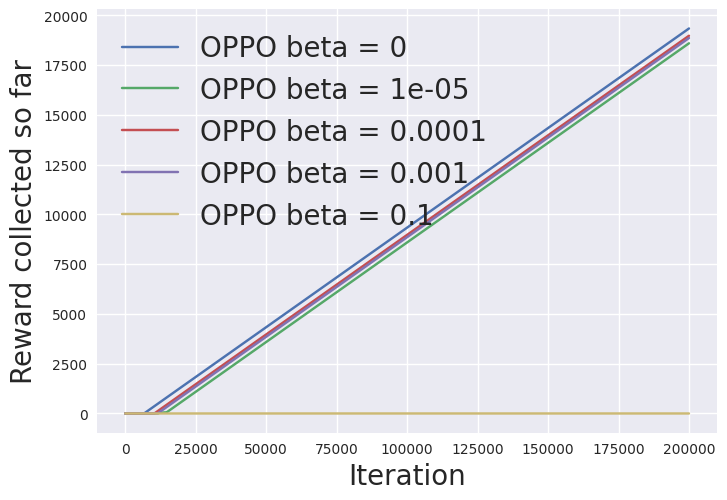

In [12]:
labels = [ f"OPPO beta = {beta}" for beta in betas]
plot_lines(
    to_plot,
    labels,
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False
)

**Question**

Why does setting $\beta = 0$ lead to bad results? 

*Hint: Explain using the remarks in slide 28 and the theoretical bound in Slide 22 of Lecture 5*.

**Answer**

The $\beta$ paramter in OPPO is used when we try to compute the bonus. This also means that we dont effectively explore the space and our updates to Q are too pessimistic leading to a large value of $\kappa$ and a high statistical error $\epsilon_{stat}$. Also setting $\beta= 0$ means that optimism does not hold since the $Q_h^{t}$ that we estimate will be pesimistic ie:

$$
Q_{h,\beta}^{t}(s, a) \leq r_h^{t}(s, a) + \sum_{s'} \hat{P}^{t}(s'| s, a) V^{t}_h(s')
$$

Meaning that $Q^{\pi_{t}}(s, a)$ will not be a fixed point of this.

If our bonus is too small it could also mean that bounded optimism will not hold anymore 

**Question**

Why does setting $\beta$ too large lead to poor results?

*Hint: Answer using the regret bound for OPPO given at the beginning of slide 30.*

**Answer**

If the beta is too large then the bonus will be too large and the value of Q will be too optimistic. This also means that our regret bound will be very large. From slide 30 we get the following regret bound:

$$
\sum^{T}_{t=1} V^{\star}(s_1) - V^{\pi_t}(s_1) \leq \mathcal{O}\left(\sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h)\right)
$$

Since the difference between our iterates and the optimial depend on the bonus, if we overestimate it by using a large $\beta$ then our difference will be very large and affect our convergence rates

# Ex 4: REINFORCE with parametrized policies (20 points)

In this exercise, we will investigate the effect of choosing different baselines in the reinforce implementation.
This topic is covered from Slide 31 on in Lecture 5.

**Hint: You may want to use Google Colab to run the experiments faster, but you don't have to.**

### Import the Necessary Packages

In [13]:
# TODO: you may need to run this to make sure to have the correct versions
!pip install gym==0.25.2
!pip install gym-notices==0.0.8

In [14]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

The CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space.

In [16]:
env = gym.make('CartPole-v0')
env.seed(0)

/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked 

[0]

In [17]:
class Policy(nn.Module): # definie the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [18]:
from tqdm.notebook import tqdm

# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in tqdm(range(1, n_episodes), total=n_episodes, desc="Running an Episode...", leave=False):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break

    return scores

**Question**

1. Find **two** good baselines that improve over the implementation of REINFORCE without baseline. You should plot their results below.

You can take inspiration from the Example Notebook we attached for lecture 4, but you **cannot use exactly the same**.

2. Explain why you chose your baselines and why you think they are reasonable.

*Note:* You may also change other parameters such as the learning rate, as long as you clearly state it in your response.

**Answer**

My first baseline makes use of a Lyapunov-like function to encourage the agent to stay in the middle of track while
keeping the pole upright as it is only 0 in this state while it is non-zero in every other state. This baseline acts as
a negative reward so we try to minimize it (i.e encouraging the system to stay in the upright state, as still as
possible and as close to the centre as possible).

My second baseline function uses a similar idea to the naive baseline from the example notebook, but I also multiply the
angle by the angular velocity and a weighting factor of 50. My idea behind this was that if I multiplied both values
together it might force the system to balance the pole quicker. By using the angular velocity in the baseline function I
also penalize the system from swinging wildly so it is less likely to get arrive in a bad state and have the pole fall down

In [19]:
from tqdm.notebook import tqdm

def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
    position, velocity, angle, angular_velocity = state
    return 0.5 * (position**2 + velocity**2 + 10 * angle**2 + angular_velocity**2)

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
    position, velocity, angle, angular_velocity = state

    value = 50* angular_velocity * angle

    return value


# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in tqdm(range(1, n_episodes), total=n_episodes, desc=f"Running epsiode with baseline {baseline.__name__}", leave=False):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            #baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
        env.close()
    return scores

In [20]:
env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 1: run REINFORCE
policy_rwd2go = Policy().to(device)
optimizer_rwd2go = optim.Adam(policy_rwd2go.parameters(), lr=1e-2)
scores_rwd2go = reinforce_rwd2go(policy_rwd2go, optimizer_rwd2go, early_stop=False, n_episodes=2000, print_every=np.inf)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, baseline=baseline_1, early_stop=False, n_episodes=2000, print_every=np.inf)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-3)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000, print_every=np.inf)



Running an Episode...:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ubuntu/miniconda3/envs/RL/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to se

Running epsiode with baseline baseline_1:   0%|          | 0/2000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/2000 [00:00<?, ?it/s]

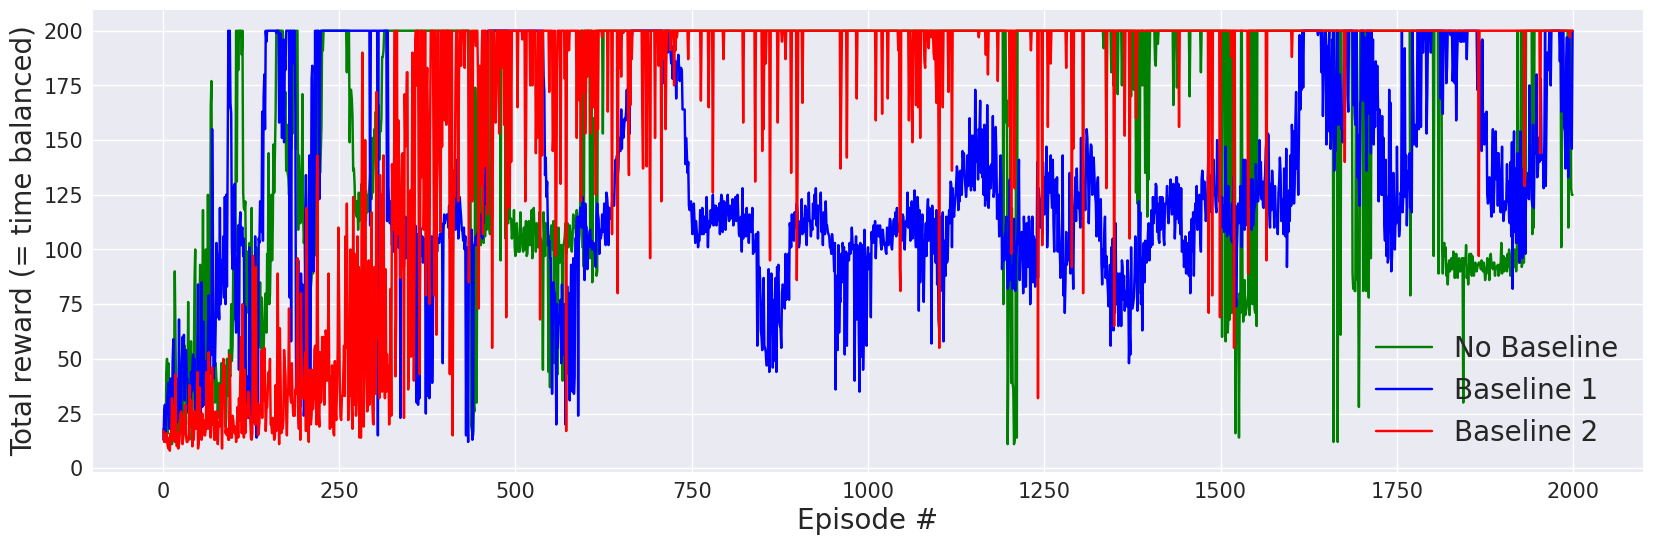

In [21]:
## Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

In [22]:
# The following code is just some experimentation that I wanted to do.


from tqdm.notebook import tqdm
N = 10

baselines = [naive_baseline, baseline_1, baseline_2]
n_episodes = 1000
scores = np.zeros((len(baselines), N, n_episodes - 1))

for i in tqdm(range(N), total=N, desc="Running Experiments", leave=False):
    for baseline in tqdm(range(len(baselines)), total=len(baselines), desc="Running baseline", leave=False):
        env = gym.make('CartPole-v0')
        env.seed(i)
        policy_baseline = Policy().to(device)
        optimizer_baseline = optim.Adam(policy_baseline.parameters(), lr=1e-2)
        scores[baseline,i] = reinforce_rwd2go_baseline(policy_baseline, optimizer_baseline, baseline=baselines[baseline], early_stop=False, n_episodes=n_episodes, print_every=np.inf)


Running Experiments:   0%|          | 0/10 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

Running baseline:   0%|          | 0/3 [00:00<?, ?it/s]

Running epsiode with baseline naive_baseline:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_1:   0%|          | 0/1000 [00:00<?, ?it/s]

Running epsiode with baseline baseline_2:   0%|          | 0/1000 [00:00<?, ?it/s]

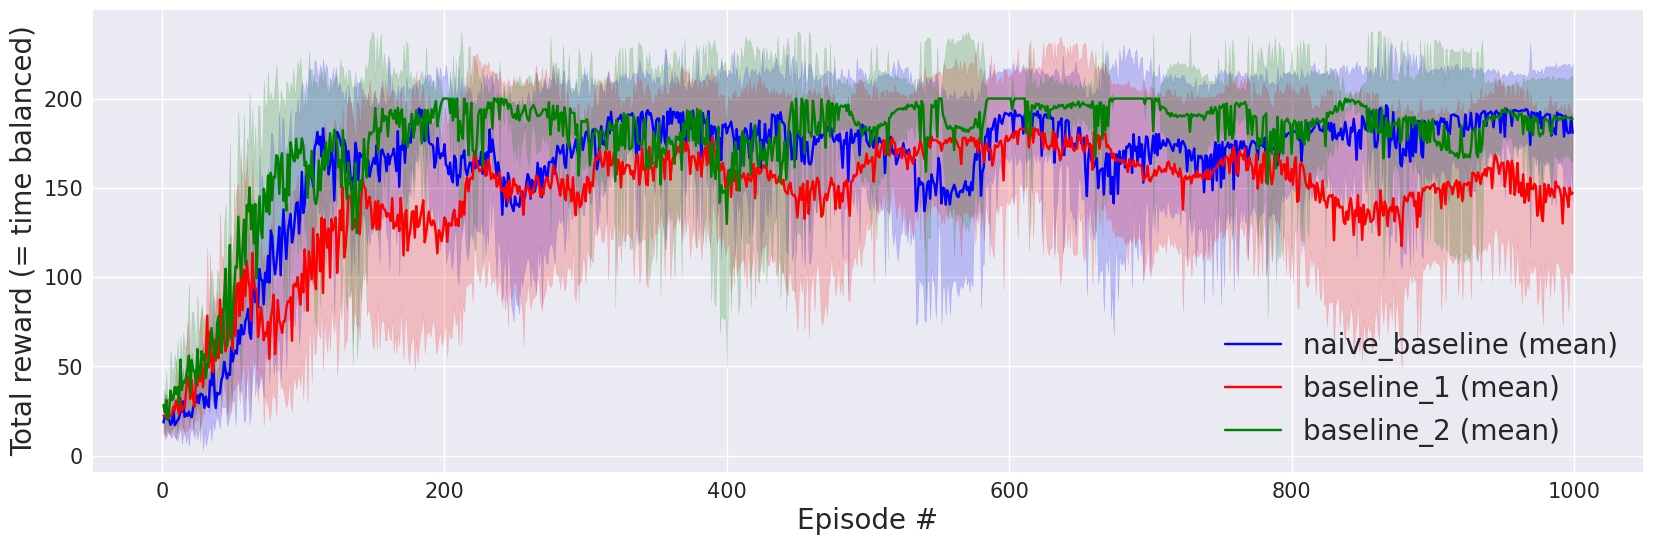

In [23]:
def plot_baselines(scores, baselines, color_list=['blue', 'red', 'green']):
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    for i in range(len(baselines)):
        name = baselines[i].__name__
        ax.plot(np.arange(1, len(scores[i].mean(axis=0)) + 1), scores[i].mean(axis=0), label=f'{name} (mean)', color=color_list[i])
        ax.fill_between(np.arange(1, len(scores[i].mean(axis=0)) + 1), scores[i].mean(axis=0) - scores[i].std(axis=0), scores[i].mean(axis=0) + scores[i].std(axis=0), alpha=0.2, color=[color_list[i]])
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=20)
    plt.show()
plot_baselines(scores, baselines)

# $Q^\star$: Policy Gradient with continuous actions and bound on the bonuses count in OPPO (20 points)
***Question 1:*** Consider using a Gaussian parameterized policy $\pi_{\mu,\Sigma}$ with mean $\mu \in \mathrm{R}^d$ 
and covariance matrix $\Sigma$ . Write down the following gradients:

$$ \nabla_\mu J(\pi_{\mu, \Sigma}) = ???$$
$$ \nabla_\Sigma J(\pi_{\mu, \Sigma}) = ???$$
***Question 2*** In this exercise, you will bound the state action counts. This is a crucial part of the OPPO convergence proof. Let $N^t_h(s,a)$ denotes the number of times the state action pair $s,a$ has been visited at step $h$ in all the episode up to $t$ included. Moreover,
let $s^t_h,a^t_h$ be the state action pair visited at step $h$ of the $t^{th}$ episode. Then, prove that 
$$ \sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \leq SA \log( T H)$$
***Question 3*** Use the fact above to prove the following bound at slide 30 of Lecture 5. That is, for $\mathrm{bonus}^t_h(s,a) = \frac{H}{\sqrt{N^t_h(s,a)}}$ it holds that
$$ \sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h) \leq \sqrt{ H^3 SA T \log( T H)}$$

**Answer**
### Question 1
From L4S18 we can see that the gradient of $J(\pi_{\mu, \Sigma})$ is generally given by:
$$
\nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim p_{\theta}}\left[\sum_{t=0}^{\infty} \gamma^{t} Q^{\pi_{\theta}}(s,
a) \nabla_{\theta}\log{(\pi_{\theta}(a_t | s_t))} \right]
$$
We now only need to compute $\nabla_{\theta}\log{(\pi_{\theta}(a_t | s_t))}$. Since we parameterize the policy as a
Gaussian, we can calculate the gradient as follows:
$$
\nabla_{\mu} \log{\pi_{\mu, \Sigma}(a_t | s_t)} = (a - \mu) \Sigma^{-1}   
$$

$$
\nabla_{\Sigma} \log{\pi_{\mu, \Sigma}(a_t | s_t)} = \frac{1}{2}\Sigma^{-1}(a - \mu)(a-\mu)^{\top}\Sigma^{-1} - \frac{1}{2}\Sigma^{-1} 
$$

We can then combine this with our expression above to get:
$$
\nabla_{\mu} J(\pi_{\mu, \Sigma}) = \mathbb{E}_{\tau \sim p_{\theta}}\left[\sum_{t=0}^{\infty} \gamma^{t} Q^{\pi_{\theta}}(s,a) (a - \mu) \Sigma^{-1} \right]
$$

$$
\nabla_{\Sigma} J(\pi_{\mu, \Sigma}) = \mathbb{E}_{\tau \sim p_{\theta}}\left[\frac{1}{2}\sum_{t=0}^{\infty} \gamma^{t} Q^{\pi_{\theta}}(s,a) \left[\Sigma^{-1} (a - \mu)(a-\mu)^{\top}\Sigma^{-1} - \Sigma^{-1}\right] \right]
$$

### Question 2
For each triple $(h,s,a)$, consider the list of times $t$ when the agent visits $(s,a)$ at step $h$.
When $(s, a)$ is encountered for the $k^{\text{th}}$ time, $N_h^{t}(s, a) = k- 1$ and so:
$$
\sum \frac{1}{N_{h}^{t}(s, a) + 1} = \sum \frac{1}{k}
$$

Since this is the harmonic series, we can use a common inequality to get:

$$
\sum_{k = 1}^{n} \frac{1}{k} \leq 1 + \log(n) \leq 1 + \log(TH)
$$

Since there are $HSA$ such triples we get the following bound:

$$
\sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \leq HSA (1 + \log(TH))
$$

*Note this isn't exactly the bound but I couldn't find a way to get rid of the additive HSA term and the extra H factor in front of the log*

### Question 3
We can use the bound from question 2 to help us prove the bound in Q3. We can rewrite the sum of the bonus as follows:

$$
    \sum_{t=1}^{T}\sum_{h=1}^{H} \frac{H}{\sqrt{N_{h}^{t}(s, a)}} = H\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{\sqrt{N_{h}^{t}(s, a)}}
$$
We can apply Cauchy-Schwarz to the second term:
$$
\begin{align*}
\left(\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{\sqrt{N_{h}^{t}(s, a)}} \right)^2 &\leq \left(\sum_{t=1}^{T}\sum_{h=1}^{H}
1\right)^2\left(\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{N_{h}^{t}(s, a)}\right) \\
&= TH\left(\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{N_{h}^{t}(s, a)}\right) \\
H\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{\sqrt{N_{h}^{t}(s, a)}} &\leq H \sqrt{TH\left(\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{1}{N_{h}^{t}(s, a)}\right)}
\end{align*}
$$
To avoid divisions by 0 we are going to consider that $N_{h}^{t}(s, a) > 0$. Then we can make use of the following
inequality:
$$
\frac{1}{x} \leq \frac{2}{x+1} \quad \forall n \geq 1
$$
Then by letting $x = N_{h}^{t}(s, a)$ we get:
$$
\begin{align*}
    \sum_{t=1}^{T}\sum_{h=1}^{H} \operatorname{bonus}_{h}^{t}(s_{h}^{t}, a_{h}^{t}) &\leq H
    \sqrt{TH\left(\sum_{t=1}^{T}\sum_{h=1}^{H} \frac{2}{N_{h}^{t}(s, a)+1}\right)} \\
    &=\sqrt{2TH^3SA\log{TH}}
\end{align*}
$$

So we have shown that:

$$
\boxed{\sum_{t=1}^{T}\sum_{h=1}^{H} \operatorname{bonus}_{h}^{t}(s_{h}^{t}, a_{h}^{t}) \leq \sqrt{2TH^3SA\log{TH}}}
$$

Since the bound in L5S30 is an asymptotic bound in big O notation we can drop the constant factor of $\sqrt{2}$ when
considering many episodes with long horizons and a large state-action space. So we finally arrive at the bound of :

$$
\boxed{\sum_{t=1}^{T}\sum_{h=1}^{H} \operatorname{bonus}_{h}^{t}(s_{h}^{t}, a_{h}^{t}) \leq \sqrt{TH^3SA\log{TH}}}
$$